In [2]:

import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.stats import pearsonr
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
wine_df = pd.read_csv(
        "https://github.com/tucros/school_datasets/blob/main/winequality-white.csv?raw=true",
        sep=";",
    )
wine_df["quality"] = wine_df["quality"].astype("category")

print("\nPreprocessing.....")
print(f"{wine_df.shape} Rows and Columns")

print("\nFrame info")
print(wine_df.info())

print("\nFrame description")
print(wine_df.describe())

null_rows = wine_df[wine_df.isnull().any(axis=1)]
print(f"\nRows with null values: {len(null_rows)}")
if len(null_rows) > 0:
    wine_df.dropna(inplace=True)

duplicate_rows = wine_df[wine_df.duplicated()]
print(f"Duplicate rows: {len(duplicate_rows)}")
if len(duplicate_rows) > 0:
    wine_df.drop_duplicates(inplace=True)


Preprocessing.....
(4898, 12) Rows and Columns

Frame info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         4898 non-null   float64 
 1   volatile acidity      4898 non-null   float64 
 2   citric acid           4898 non-null   float64 
 3   residual sugar        4898 non-null   float64 
 4   chlorides             4898 non-null   float64 
 5   free sulfur dioxide   4898 non-null   float64 
 6   total sulfur dioxide  4898 non-null   float64 
 7   density               4898 non-null   float64 
 8   pH                    4898 non-null   float64 
 9   sulphates             4898 non-null   float64 
 10  alcohol               4898 non-null   float64 
 11  quality               4898 non-null   category
dtypes: category(1), float64(11)
memory usage: 426.2 KB
None

Frame description
       fixed acidity  vol

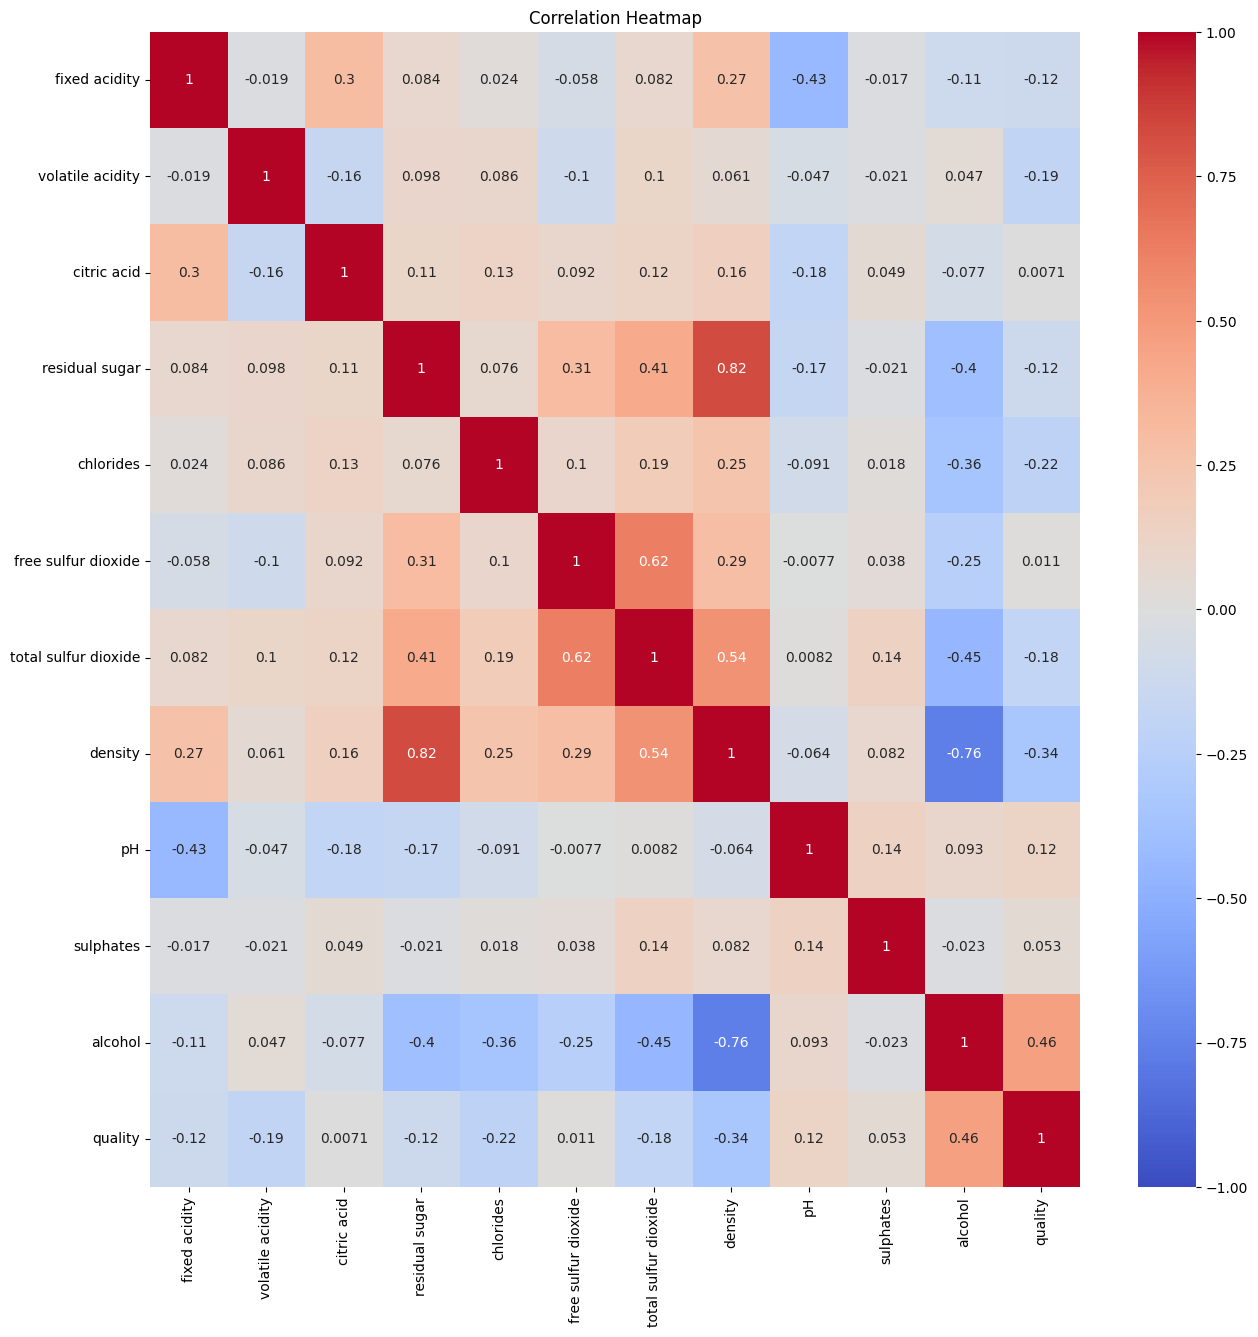

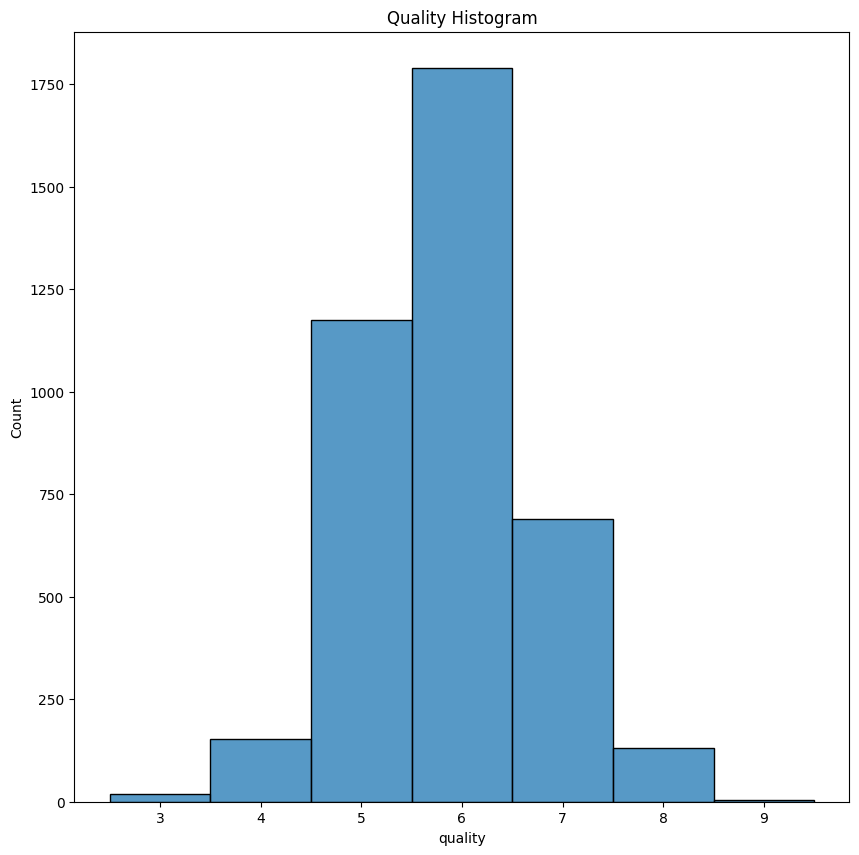

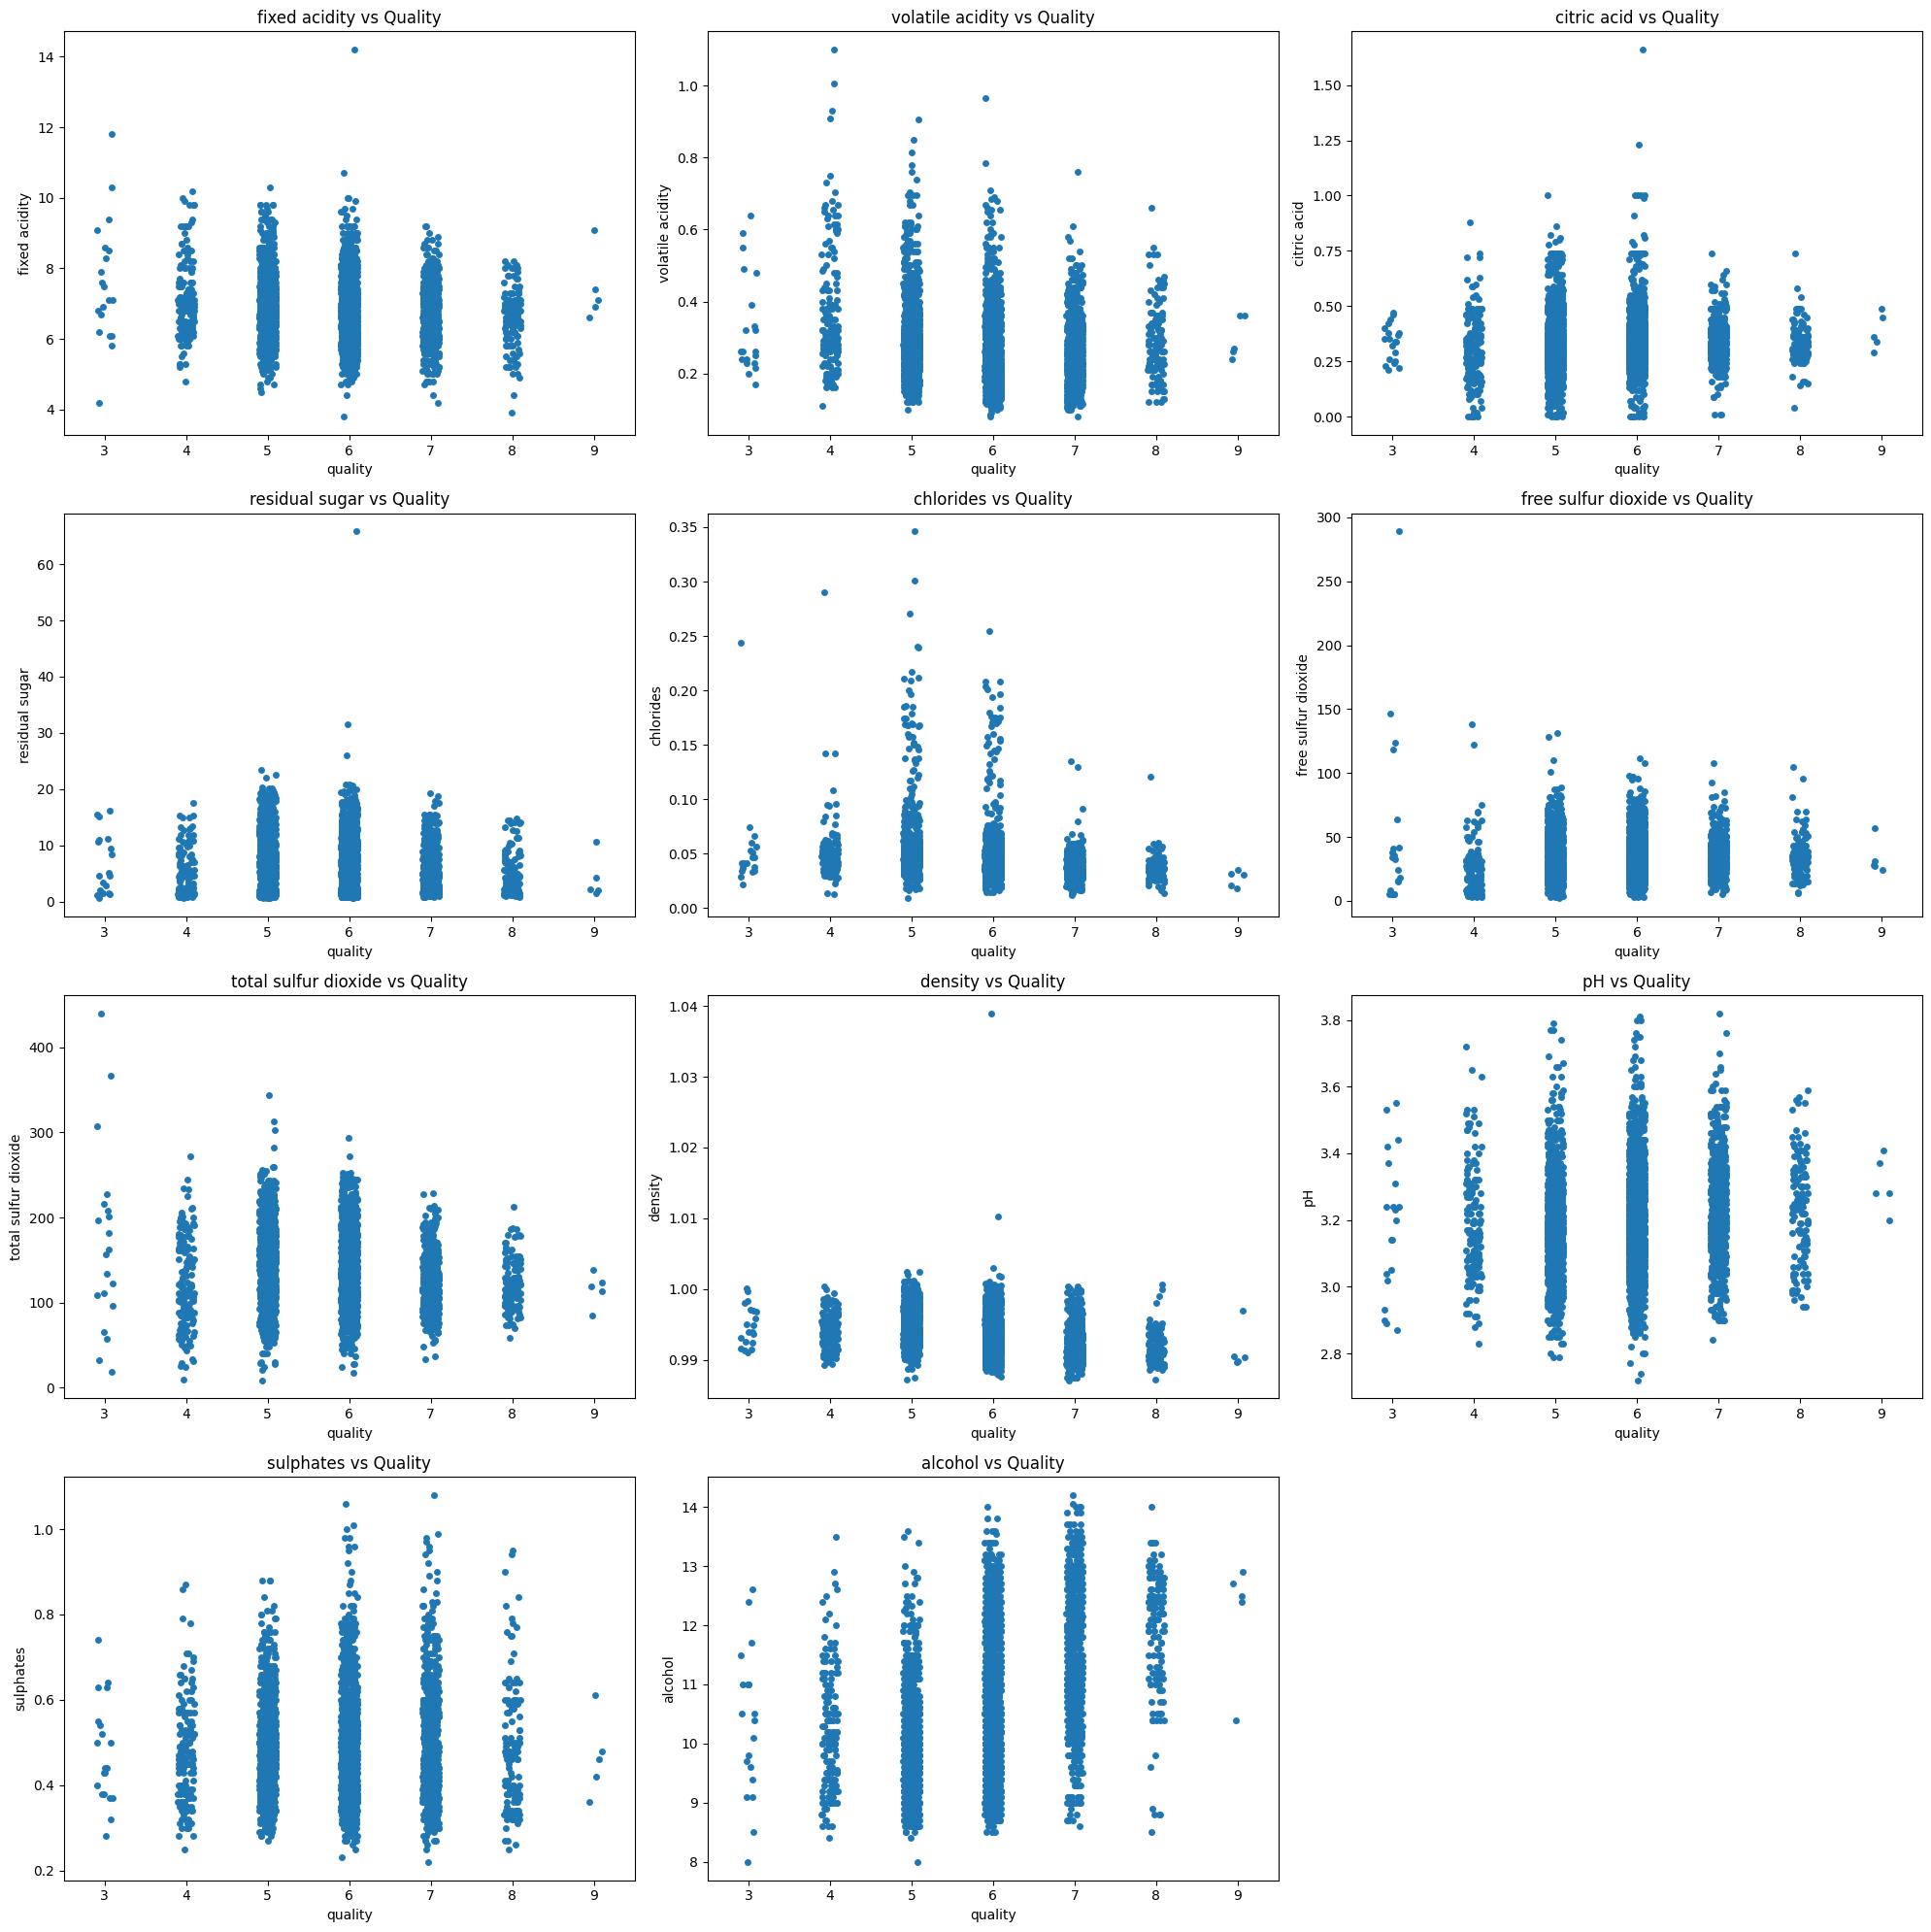

In [4]:
plt.figure(figsize=(15, 15))
sns.heatmap(wine_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 10))
sns.histplot(wine_df["quality"], bins=10)
plt.title("Quality Histogram")
plt.show()

plt.figure(figsize=(20, 20))
for i, column in enumerate(wine_df.columns):
    if column != "quality":
        plt.subplot(4, 3, i + 1)
        sns.stripplot(x="quality", y=column, data=wine_df, jitter=True)
        plt.title(f"{column} vs Quality")
plt.tight_layout()
plt.show()


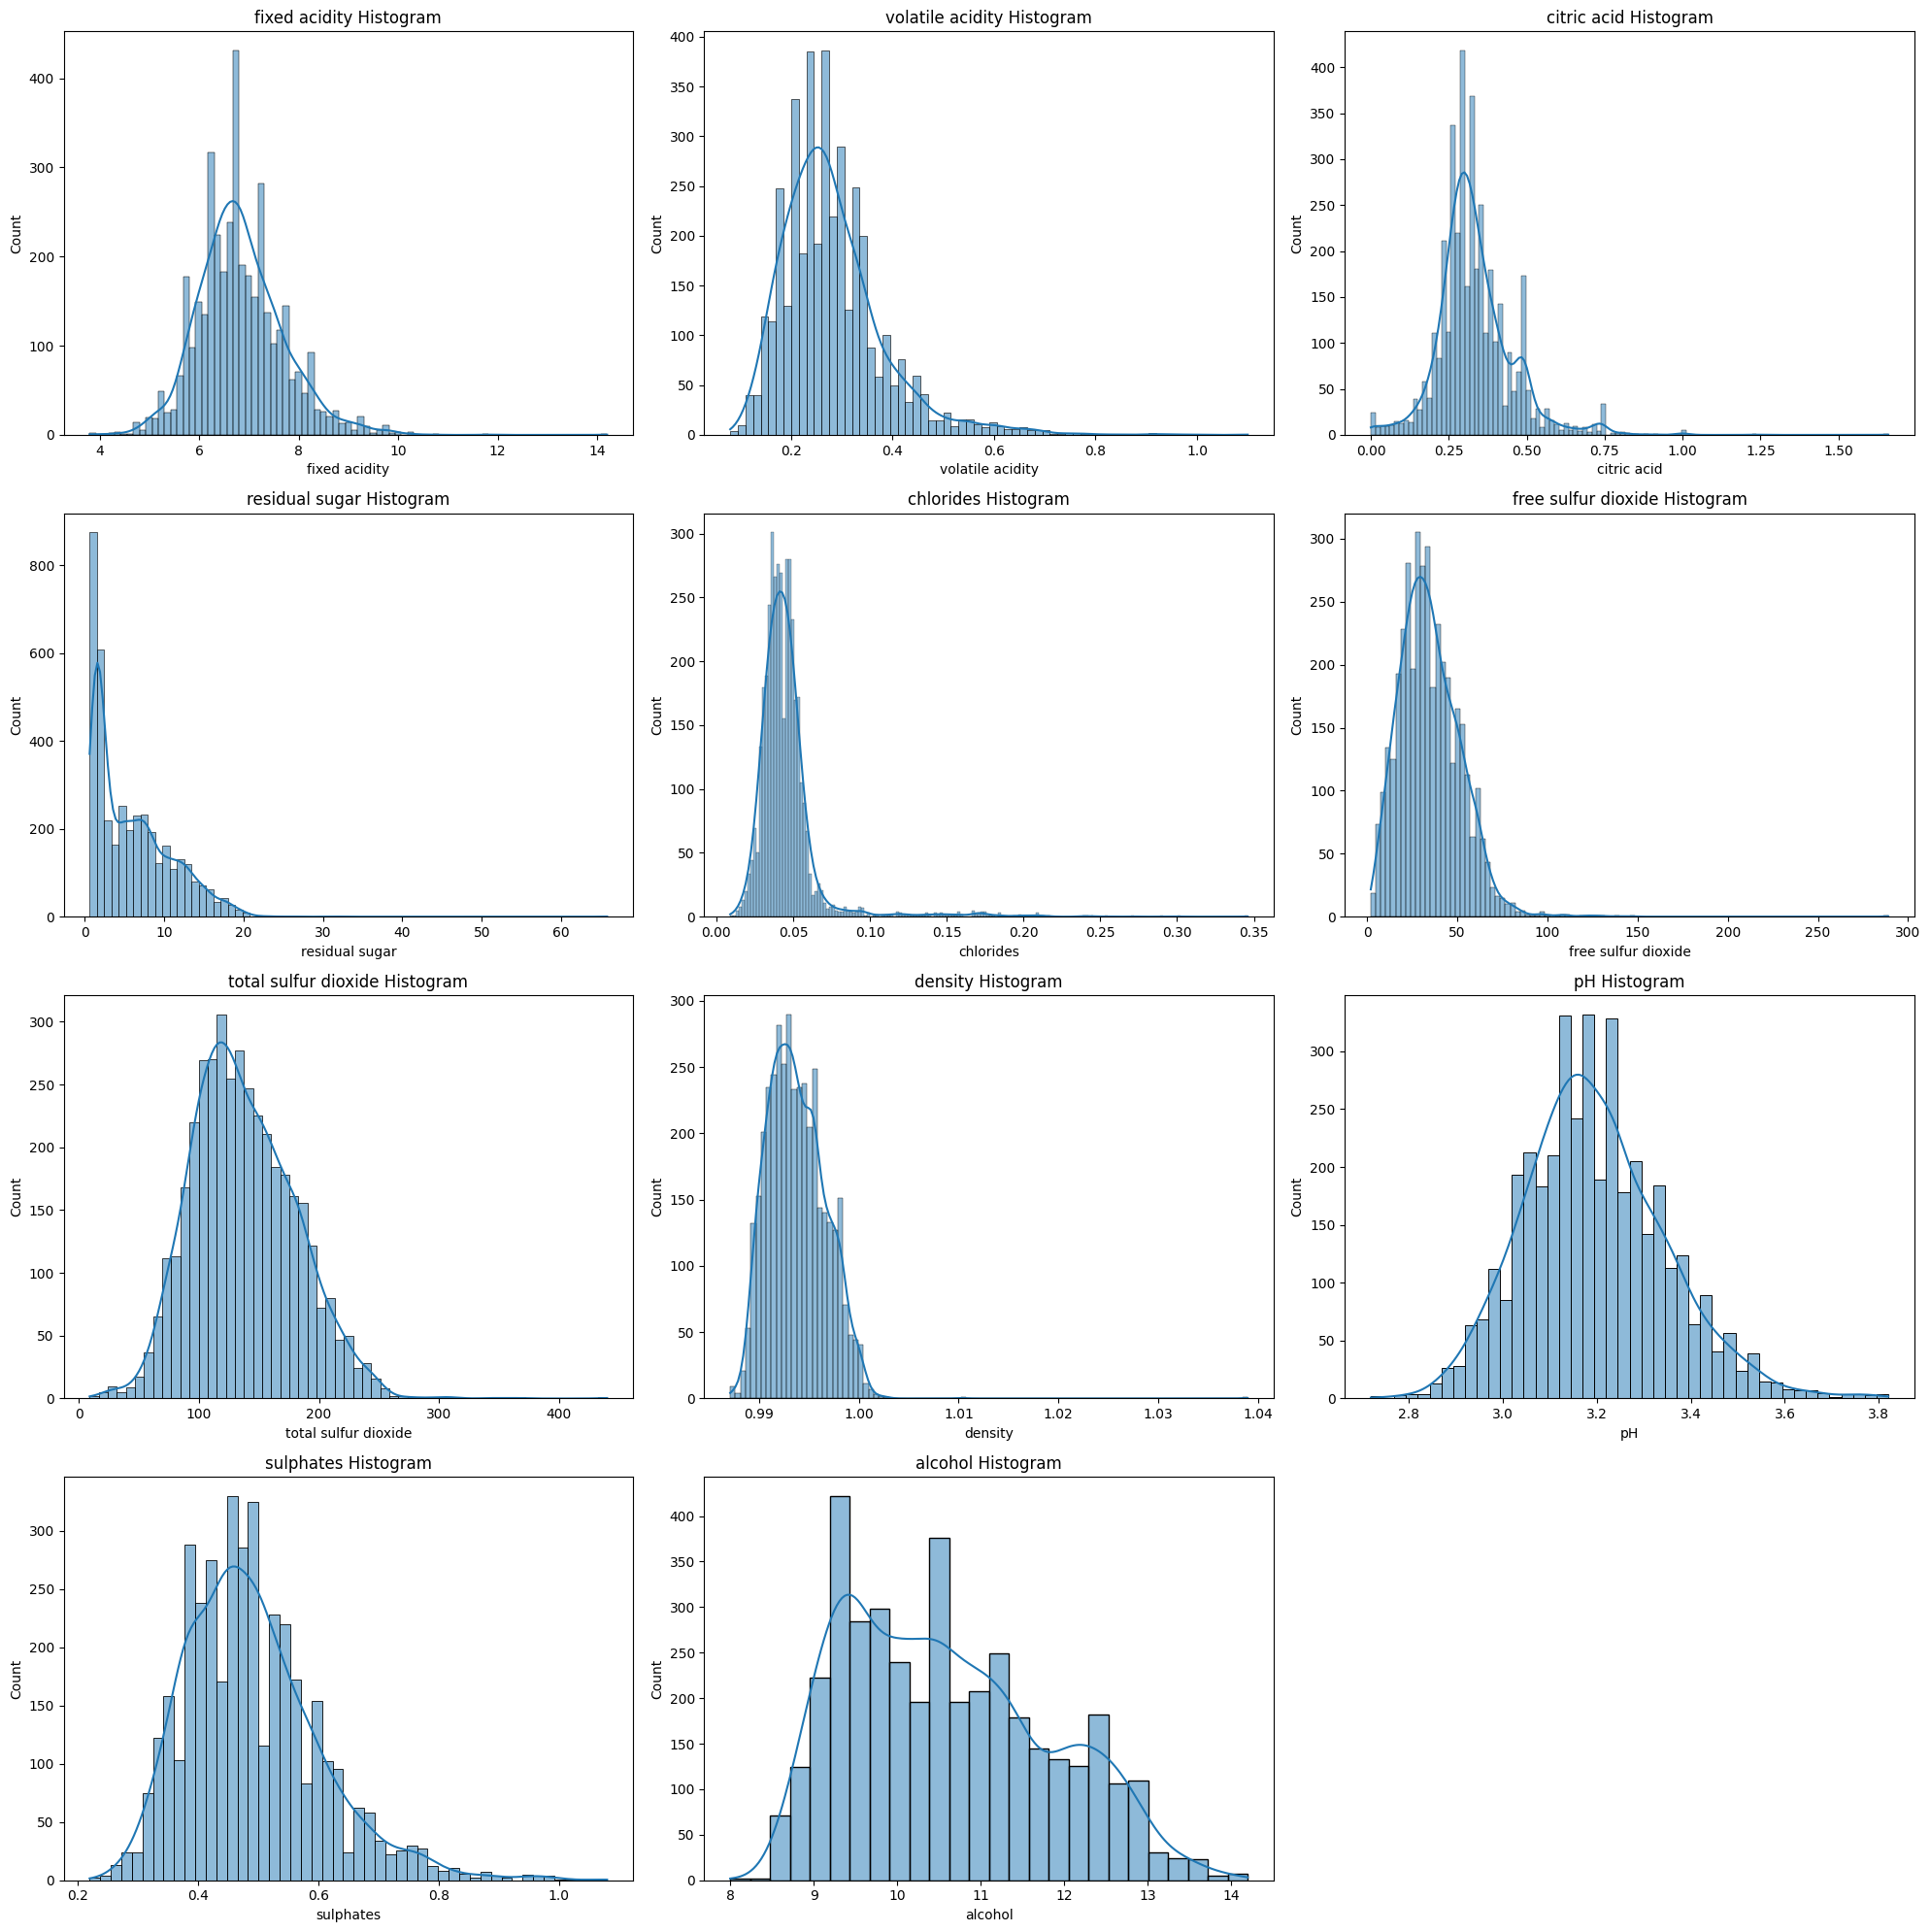

In [5]:
plt.figure(figsize=(20, 20))
cnt = 0
for column in wine_df.columns:
    if column != {"quality", "highquality"}:
        plt.subplot(4, 3, cnt + 1)
        sns.histplot(wine_df[column], kde=True)
        plt.title(f"{column} Histogram")
        cnt += 1
plt.tight_layout()
plt.show()

In [6]:
features = wine_df.drop("quality", axis=1)
target = wine_df["quality"]

# Determine feature correlation with quality
alpha = 0.05
remove_cols = []
for column in features.columns:
    _, pval = pearsonr(features[column], target)
    print(f"{column} vs quality pval: {pval}")
    if pval > alpha:
        remove_cols.append(column)

print(f"Removing {len(remove_cols)} uncorrelated columns")
if len(remove_cols) > 0:
    print(f"Removing {remove_cols}")
    features.drop(remove_cols, axis=1, inplace=True)

# NOTE: Convert target to binary representing high quality wines
wine_df["highquality"] = wine_df["quality"].apply(lambda x: 1 if x >= 7 else 0)

highquality_percentage = wine_df["highquality"].value_counts(normalize=True) * 100
print(f"Percentage of each class in 'highquality':\n{highquality_percentage}")
# NOTE: No need to scale since we are using tree-based models

fixed acidity vs quality pval: 3.4788252315722896e-15
volatile acidity vs quality pval: 9.570472304980674e-34
citric acid vs quality pval: 0.6566933911784069
residual sugar vs quality pval: 1.2803114935604259e-13
chlorides vs quality pval: 1.0170578797809447e-43
free sulfur dioxide vs quality pval: 0.5085713225106695
total sulfur dioxide vs quality pval: 2.7389983717235244e-31
density vs quality pval: 2.570127886850179e-106
pH vs quality pval: 5.240854950385928e-15
sulphates vs quality pval: 0.0008094044619297985
alcohol vs quality pval: 1.428531029114038e-209
Removing 2 uncorrelated columns
Removing ['citric acid', 'free sulfur dioxide']
Percentage of each class in 'highquality':
highquality
0    79.171926
1    20.828074
Name: proportion, dtype: float64


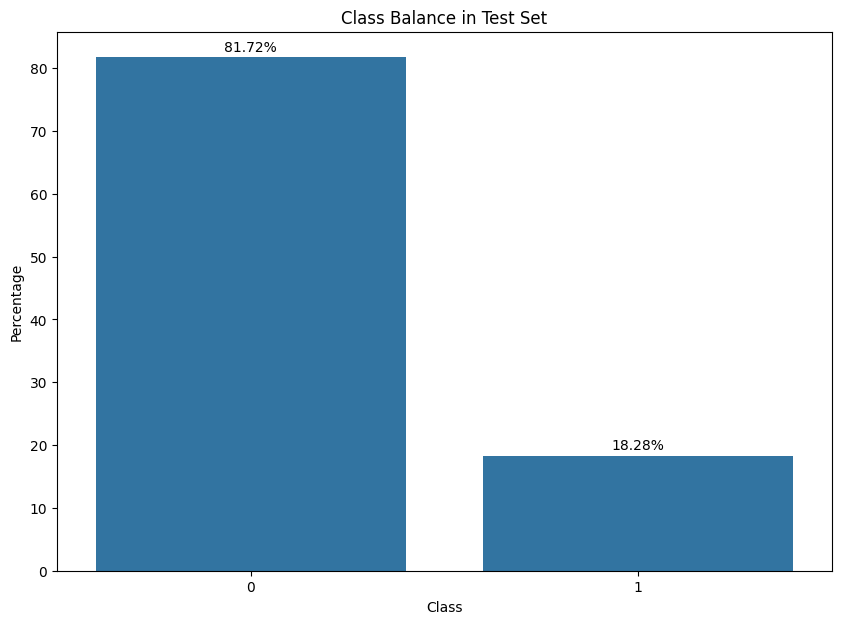

In [7]:
X = wine_df.drop(["quality", "highquality"], axis=1)
y = wine_df["highquality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

class_counts_test = y_test.value_counts(normalize=True) * 100
plt.figure(figsize=(10, 7))
sns.barplot(x=class_counts_test.index, y=class_counts_test.values)
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.title("Class Balance in Test Set")
for i, value in enumerate(class_counts_test.values):
    plt.text(i, value + 1, f"{value:.2f}%", ha="center")
plt.show()


In [8]:
def visualize_decision_tree(clf, data):
    dot_data = tree.export_graphviz(
        clf.best_estimator_,
        out_file=None,
        feature_names=data.columns,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(graph)


def visualize_random_forest(clf, data):
    dot_data = tree.export_graphviz(
        clf.best_estimator_.estimators_[0],
        out_file=None,
        feature_names=data.columns,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(graph)


def visualize_adaboost(clf, data):
    # TODO: Implement
    pass


def visualize_xgboost(clf, data):
    # TODO: Implement
    pass

In [9]:
CLASSIFIERS = [
    (
        DecisionTreeClassifier(),
        {
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
        visualize_decision_tree,
    ),
    (
        RandomForestClassifier(),
        {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
        visualize_random_forest,
    ),
    (
        AdaBoostClassifier(algorithm="SAMME"),
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.5, 1],
        },
        visualize_adaboost,
    ),
    (
        XGBClassifier(),
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.5, 1],
            "max_depth": [3, 5, 7],
        },
        visualize_xgboost,
    ),
]


Training DecisionTreeClassifier


c:\Users\cb314\anaconda3\envs\introsl\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Training Accuracy for DecisionTreeClassifier: 0.8008187938862061
Testing Accuracy: 0.8133669609079445
Precision: 0.4716981132075472
Recall: 0.1724137931034483
F1 Score: 0.25252525252525254
Classification Report: 
 DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       648
           1       0.47      0.17      0.25       145

    accuracy                           0.81       793
   macro avg       0.65      0.56      0.57       793
weighted avg       0.77      0.81      0.78       793



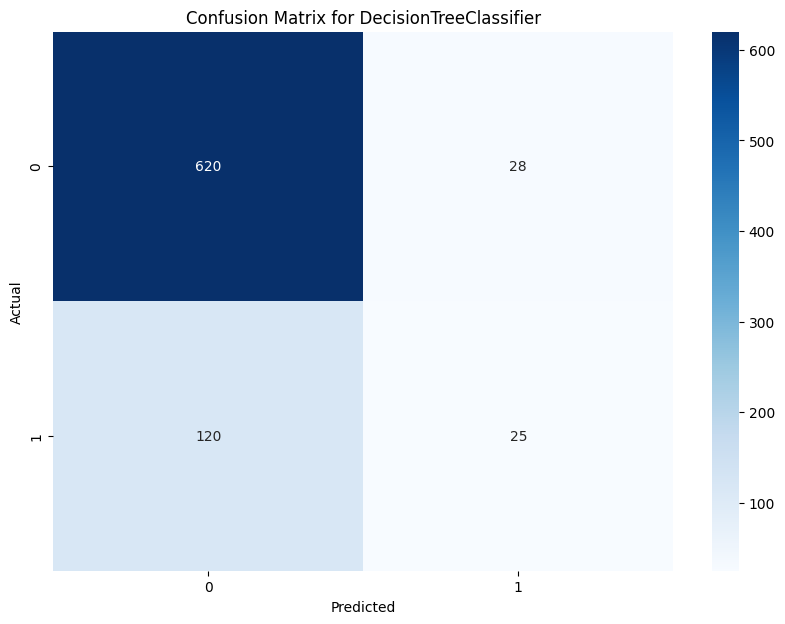

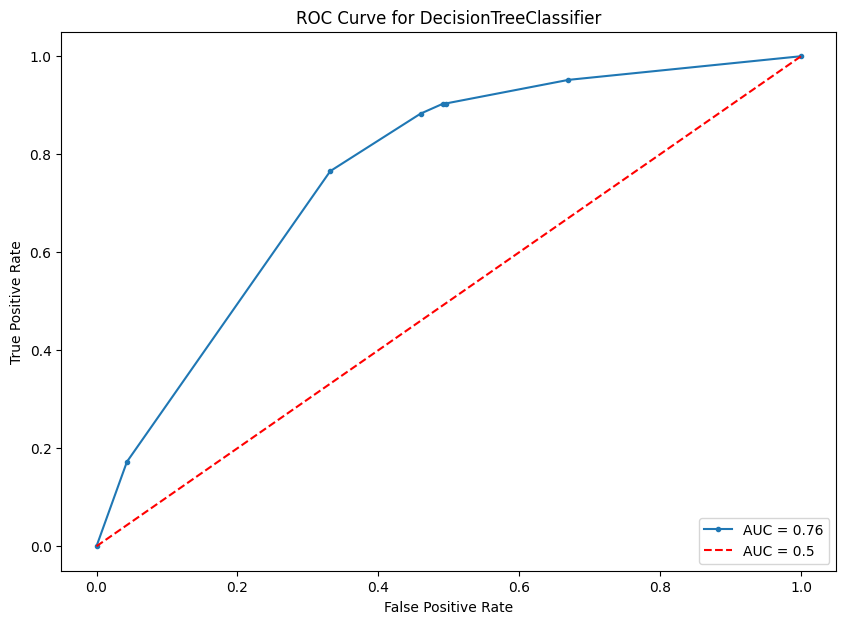

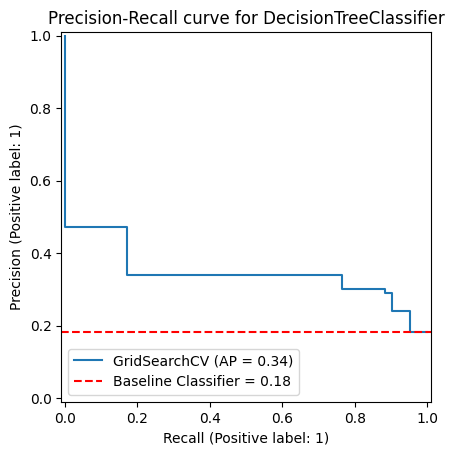

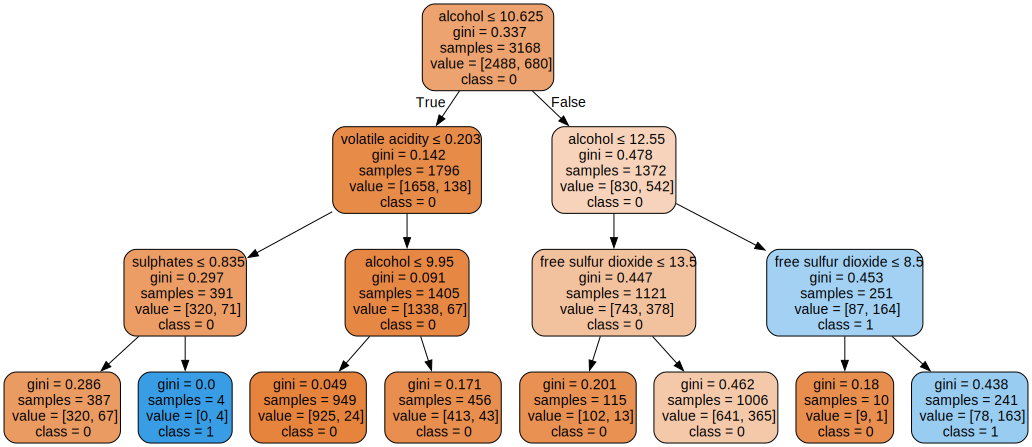


Training RandomForestClassifier


In [10]:
for model, params, viz_fn in CLASSIFIERS:
    print(f"\nTraining {model.__class__.__name__}")
    clf = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring="accuracy")
    clf.fit(X_train, y_train)

    # TODO: All the evaluation code
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Training Accuracy for {model.__class__.__name__}: {clf.best_score_}")

    ### predict and evaluate on test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Testing Accuracy: {accuracy}")

    ### precision, recall and f1 score
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary"
    )
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

    ### Classifcation report
    print(
        f"Classification Report: \n {model.__class__.__name__}\n{classification_report(y_test, y_pred)}"
    )

    ### confusion matrix and show plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

    # calculate roc curve and auc
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # plot roc curve for the model
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, marker=".", label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="AUC = 0.5")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model.__class__.__name__}")
    plt.legend(loc="lower right")
    plt.show()

    # plot precision-recall curve for the model
    precision_recall_display = PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test
    )
    class_counts = y_test.value_counts(normalize=True)
    plt.axhline(
        y=class_counts[1],
        color="r",
        linestyle="--",
        label=f"Baseline Classifier = {class_counts[1]:.2f}",
    )
    plt.legend(loc="lower left")
    plt.title(f"Precision-Recall curve for {model.__class__.__name__}")
    plt.show()

    viz_fn(clf, X_train)
